In [ ]:
import tensorflow as tf 
import pandas as pd
import numpy as np 
import glob 
import random
import matplotlib.pyplot as plt

from tensorflow import keras 

In [ ]:
#KAGGLE CODE IMPORT CODE
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d amanneo/diabetic-retinopathy-resized-arranged

 99% 1.20G/1.21G [00:11<00:00, 102MB/s] 
100% 1.21G/1.21G [00:11<00:00, 115MB/s]


In [ ]:
#UNZIP THE DATA DOWNLOADED FROM KAGGLE 
import zipfile
local_zip = '/content/diabetic-retinopathy-resized-arranged.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

The folder represents specific class labels.
0 - No DR
1 - Mild
2 - Moderate
3 - Severe
4 - Proliferative DR

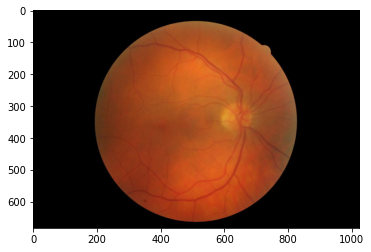

In [ ]:
## non-proliferative diabetic retinopathy
test_img = glob.glob('/content/0/*jpeg')
img_select = random.randint(1,len(test_img))
img = plt.imread(test_img[img_select])
plt.imshow(img)

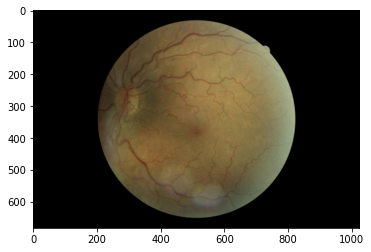

In [ ]:
#proliferative diabetic retinopathy
test_img = glob.glob('/content/1/*jpeg')
img_select = random.randint(1,len(test_img))
img = plt.imread(test_img[img_select])
plt.imshow(img)

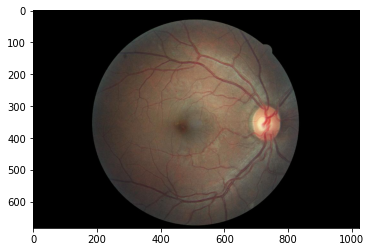

In [ ]:
test_img = glob.glob('/content/2/*jpeg')
img_select = random.randint(1,len(test_img))
img = plt.imread(test_img[img_select])
plt.imshow(img)

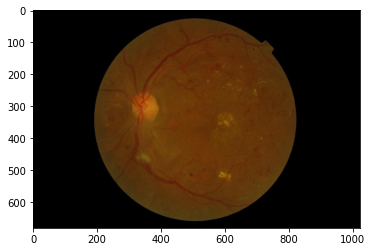

In [ ]:
test_img = glob.glob('/content/3/*jpeg')
img_select = random.randint(1,len(test_img))
img = plt.imread(test_img[img_select])
plt.imshow(img)

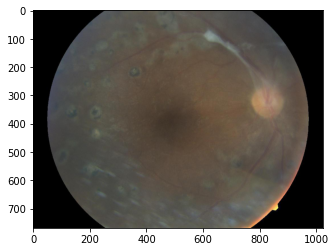

In [ ]:
test_img = glob.glob('/content/4/*jpeg')
img_select = random.randint(1,len(test_img))
img = plt.imread(test_img[img_select])
plt.imshow(img)